In [1]:
import gc
import pandas as pd 
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [3]:
train_data=pd.read_csv("../data/BusinessTrack/RAW_training_set.csv")
test_data=pd.read_csv("../data/BusinessTrack/RAW_test_set.csv")
player_data=pd.read_csv("../data/BusinessTrack/RAW_player_data.csv")
game_data=pd.read_csv("../data/BusinessTrack/RAW_game_data.csv")

In [4]:
train_by=pd.read_csv("../data/BusinessTrack/training_with_br_reference v5.csv")

C:\Wesley_Tao\6.Software\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
test_by =pd.read_csv("../data/BusinessTrack/test_set_all_variables v2.csv")

# Feature Extraction

# 0 power rankning

In [6]:
train_power=train_by[['Game_ID','Country','Away_PR','Home_PR','Avg_PR']]
test_power=test_by[['Game_ID','Away_PR','Home_PR','Avg_PR']]

In [7]:
train_data=pd.merge(train_data,train_power,left_on=['Game_ID','Country'],right_on=['Game_ID','Country'])

In [8]:
train_data['Away_PR_2']=np.power(train_data['Away_PR'],2)
train_data['Home_PR_2']=np.power(train_data['Home_PR'],2)
train_data['Avg_PR_2']=np.power(train_data['Avg_PR'],2)

In [9]:
test_data=pd.merge(test_data,test_power,on=['Game_ID'])
test_data['Away_PR_2']=np.power(test_data['Away_PR'],2)
test_data['Home_PR_2']=np.power(test_data['Home_PR'],2)
test_data['Avg_PR_2']=np.power(test_data['Avg_PR'],2)

## 1 All star number
We believe the number of all star players will play a important role in views prediction  
The intuition is if a team has more popular team players, people are more likely to watch that game

In [10]:
all_start_id = player_data['ASG_Team']!='None'
all_star = player_data.loc[all_start_id,['Team','Name']].sort_values(by='Team').reset_index(drop=True)
all_star = all_star.drop_duplicates().reset_index(drop=True)
all_star_number = all_star.groupby("Team").count().reset_index()
all_star_number.columns = ['Team','Count_ASG']
patch = pd.DataFrame()
patch['Team']=list(set(train_data['Away_Team'])-set(all_star_number['Team']))
patch['Count_ASG']=0
all_star_number=pd.concat([all_star_number,patch],axis=0).reset_index(drop=True)

In [11]:
all_star_number.head()

Team  Count_ASG
0  ATL          1
1  BOS          3
2  CHA          1
3  CHI          1
4  CLE          3

In [12]:
train_data.head()

Season   Game_ID   Game_Date Away_Team Home_Team Country  Rounded Viewers  \
0  2016-17  21600001  10/25/2016       NYK       CLE    C113               18   
1  2016-17  21600001  10/25/2016       NYK       CLE    C193                1   
2  2016-17  21600001  10/25/2016       NYK       CLE    C126                4   
3  2016-17  21600001  10/25/2016       NYK       CLE    C163               11   
4  2016-17  21600001  10/25/2016       NYK       CLE     C73                3   

   Away_PR  Home_PR  Avg_PR  Away_PR_2  Home_PR_2  Avg_PR_2  
0     21.0      1.0    11.0      441.0        1.0     121.0  
1     21.0      1.0    11.0      441.0        1.0     121.0  
2     21.0      1.0    11.0      441.0        1.0     121.0  
3     21.0      1.0    11.0      441.0        1.0     121.0  
4     21.0      1.0    11.0      441.0        1.0     121.0

In [14]:
# pd.merge(train_data,all_star_number,how='outer',left_on='Away_Team',right_on='Team')

In [15]:
train_data=pd.merge(train_data,all_star_number,how='outer',left_on='Away_Team',right_on='Team')
train_data=train_data.drop(columns=['Team']).rename(mapper={"Count_ASG":"Away_Count_ASG"},axis='columns')

In [17]:
# train_data.head()

In [18]:
train_data=pd.merge(train_data,all_star_number,how='outer',left_on='Home_Team',right_on='Team')
train_data=train_data.drop(columns=['Team']).rename(mapper={"Count_ASG":"Home_Count_ASG"},axis='columns')

In [19]:
test_data=pd.merge(test_data,all_star_number,how='outer',left_on='Away_Team',right_on='Team')
test_data=test_data.drop(columns=['Team']).rename(mapper={"Count_ASG":"Away_Count_ASG"},axis='columns')
test_data=pd.merge(test_data,all_star_number,how='outer',left_on='Home_Team',right_on='Team')
test_data=test_data.drop(columns=['Team']).rename(mapper={"Count_ASG":"Home_Count_ASG"},axis='columns')

In [21]:
# train_data.head()

## 2.Date
we believe weekday or month will influence the future trend.

In [22]:
train_data['Game_Date']=pd.to_datetime(train_data['Game_Date'])
train_data['day_of_week']=train_data['Game_Date'].dt.weekday_name
train_data['month']=train_data['Game_Date'].dt.month
test_data['Game_Date']=pd.to_datetime(test_data['Game_Date'])
test_data['day_of_week']=test_data['Game_Date'].dt.weekday_name
test_data['month']=test_data['Game_Date'].dt.month
train_data.to_csv("../output/train.csv",index=False)
test_data.to_csv("../output/test.csv",index=False)

In [2]:
train_data=pd.read_csv("../output/train.csv")
test_data=pd.read_csv("../output/test.csv")

In [3]:
train_data.head()

Season   Game_ID   Game_Date Away_Team Home_Team Country  Rounded Viewers  \
0  2016-17  21600001  2016-10-25       NYK       CLE    C113               18   
1  2016-17  21600001  2016-10-25       NYK       CLE    C193                1   
2  2016-17  21600001  2016-10-25       NYK       CLE    C126                4   
3  2016-17  21600001  2016-10-25       NYK       CLE    C163               11   
4  2016-17  21600001  2016-10-25       NYK       CLE     C73                3   

   Away_PR  Home_PR  Avg_PR  Away_PR_2  Home_PR_2  Avg_PR_2  Away_Count_ASG  \
0     21.0      1.0    11.0      441.0        1.0     121.0               2   
1     21.0      1.0    11.0      441.0        1.0     121.0               2   
2     21.0      1.0    11.0      441.0        1.0     121.0               2   
3     21.0      1.0    11.0      441.0        1.0     121.0               2   
4     21.0      1.0    11.0      441.0        1.0     121.0               2   

   Home_Count_ASG day_of_week  month  
0               3     Tuesday     10  
1               3     Tuesday     10  
2               3     Tuesday     10  
3               3     Tuesday     10  
4               3     Tuesday     10

In [4]:
test_data.head()

Season   Game_ID   Game_Date Away_Team Home_Team  Total_Viewers  Away_PR  \
0  2016-17  21600010  2016-10-26       DEN       NOP            NaN    24.00   
1  2016-17  21601158  2017-04-04       DEN       NOP            NaN    15.25   
2  2016-17  21600148  2016-11-14       BOS       NOP            NaN     8.50   
3  2016-17  21600539  2017-01-05       ATL       NOP            NaN    15.00   
4  2017-18  21700373  2017-12-08       SAC       NOP            NaN    27.25   

   Home_PR  Avg_PR  Away_PR_2  Home_PR_2    Avg_PR_2  Away_Count_ASG  \
0    26.00  25.000   576.0000   676.0000  625.000000               0   
1    21.00  18.125   232.5625   441.0000  328.515625               0   
2    27.50  18.000    72.2500   756.2500  324.000000               3   
3    26.00  20.500   225.0000   676.0000  420.250000               1   
4    15.25  21.250   742.5625   232.5625  451.562500               1   

   Home_Count_ASG day_of_week  month  
0               2   Wednesday     10  
1               2     Tuesday      4  
2               2      Monday     11  
3               2    Thursday      1  
4               2      Friday     12

## 3.country

In [5]:
print("there are {} countries.".format(len(np.unique(train_data['Country']))))

there are 228 countries.


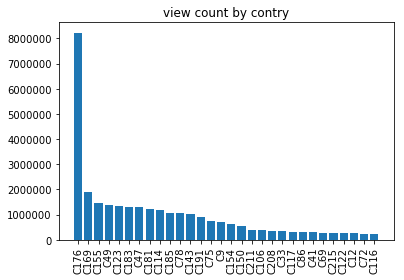

In [8]:
view_table=pd.pivot_table(train_data,values='Rounded Viewers',index='Country',aggfunc=np.sum)
view_table=view_table.sort_values(by=['Rounded Viewers'],ascending=False)
label=view_table.index[0:30]
value=view_table.values[0:30]
index=np.arange(len(label))
plt.bar(index,value)
plt.xticks(index,label,rotation=90)
plt.title("view count by contry")
plt.show()

In [ ]:
# choose top 50 and put all other into 'others' catogory

In [9]:
top_50_country=view_table.index[0:50]
top_50_idx    =list(map(lambda thiscountry: True if thiscountry in top_50_country else False, train_data['Country']))
not_top_50_idx=[not idx  for idx in top_50_idx]

In [31]:
# print ("top 50 country shape",train_data[top_50_idx].shape)
# print("reset shape ",train_data[not_top_50_idx].shape) reset shape  (180637, 11)
# print("total data shape",train_data.shape) total data shape (280625, 11)

In [10]:
train_data_half_50  = train_data[top_50_idx].copy()
train_data_half_other = train_data[not_top_50_idx].copy()

In [11]:
train_data_half_other.head()

Season   Game_ID   Game_Date Away_Team Home_Team Country  Rounded Viewers  \
0  2016-17  21600001  2016-10-25       NYK       CLE    C113               18   
1  2016-17  21600001  2016-10-25       NYK       CLE    C193                1   
2  2016-17  21600001  2016-10-25       NYK       CLE    C126                4   
3  2016-17  21600001  2016-10-25       NYK       CLE    C163               11   
4  2016-17  21600001  2016-10-25       NYK       CLE     C73                3   

   Away_PR  Home_PR  Avg_PR  Away_PR_2  Home_PR_2  Avg_PR_2  Away_Count_ASG  \
0     21.0      1.0    11.0      441.0        1.0     121.0               2   
1     21.0      1.0    11.0      441.0        1.0     121.0               2   
2     21.0      1.0    11.0      441.0        1.0     121.0               2   
3     21.0      1.0    11.0      441.0        1.0     121.0               2   
4     21.0      1.0    11.0      441.0        1.0     121.0               2   

   Home_Count_ASG day_of_week  month  
0               3     Tuesday     10  
1               3     Tuesday     10  
2               3     Tuesday     10  
3               3     Tuesday     10  
4               3     Tuesday     10

In [12]:
aggregate_df =train_data_half_other.groupby(['Game_ID']).sum()

In [13]:
aggregate_df=aggregate_df[['Rounded Viewers']]
aggregate_df.reset_index(inplace=True)

In [14]:
aggregate_df['Country']='other'
aggregate_df.sort_values(['Game_ID'],inplace=True)

In [15]:
train_data_half_other.head()

Season   Game_ID   Game_Date Away_Team Home_Team Country  Rounded Viewers  \
0  2016-17  21600001  2016-10-25       NYK       CLE    C113               18   
1  2016-17  21600001  2016-10-25       NYK       CLE    C193                1   
2  2016-17  21600001  2016-10-25       NYK       CLE    C126                4   
3  2016-17  21600001  2016-10-25       NYK       CLE    C163               11   
4  2016-17  21600001  2016-10-25       NYK       CLE     C73                3   

   Away_PR  Home_PR  Avg_PR  Away_PR_2  Home_PR_2  Avg_PR_2  Away_Count_ASG  \
0     21.0      1.0    11.0      441.0        1.0     121.0               2   
1     21.0      1.0    11.0      441.0        1.0     121.0               2   
2     21.0      1.0    11.0      441.0        1.0     121.0               2   
3     21.0      1.0    11.0      441.0        1.0     121.0               2   
4     21.0      1.0    11.0      441.0        1.0     121.0               2   

   Home_Count_ASG day_of_week  month  
0               3     Tuesday     10  
1               3     Tuesday     10  
2               3     Tuesday     10  
3               3     Tuesday     10  
4               3     Tuesday     10

In [16]:
train_data_half_other_info=train_data_half_other.drop(columns=['Country','Rounded Viewers']).drop_duplicates()

In [17]:
aggregate_df=aggregate_df.merge(train_data_half_other_info, left_on='Game_ID', right_on='Game_ID', how='outer')

In [19]:
new_train_data=pd.concat([aggregate_df,train_data_half_50],axis=0)

In [20]:
country_list=list(set(new_train_data['Country']))

In [21]:
country_df=pd.DataFrame(country_list,columns=['Country'])
# country_df
country_df['key'] = 0
test_data['key'] = 0
new_test=pd.merge(test_data,country_df,on='key')
del new_test['key']

In [22]:
# new_test.shape[0]==len(country_df)*len(test_data)

In [23]:
test=new_test
train=new_train_data
# del new_test
# del new_train_data

In [24]:
gc.collect()

145

In [137]:
# view_table=pd.pivot_table(train,values='Rounded Viewers',index='Country',aggfunc=np.sum)
# view_table=view_table.sort_values(by=['Rounded Viewers'],ascending=False)
# label=view_table.index
# value=view_table.values
# index=np.arange(len(label))
# plt.bar(index,value)
# plt.xticks(index,label,rotation=90)
# plt.title("view count by contry")
# plt.show()

# Categorical encoder

In [25]:
y_train=train['Rounded Viewers']
y_train_log =np.log1p(y_train)
X_train=train.drop(columns=['Rounded Viewers'])
X_train['month']=X_train['month'].astype('category')
# X_train=pd.get_dummies(X_train,drop_first=True)
del X_train['Game_ID']
del X_train['Game_Date']

In [26]:
X_test=test.drop(columns=['Total_Viewers','Game_ID',"Game_Date"])
X_test['month']=X_test['month'].astype('category')
X_test=X_test.sort_index(axis=1)

In [27]:
cat_col =['Away_Team','Home_Team','Season','day_of_week','month','Country']

In [28]:
for feature in cat_col:
    if feature !="month":
        X_train[feature]=X_train[feature].astype('category')
        X_test[feature]=X_test[feature].astype('category')

# light GBM
LightGBM offers good accuracy with integer-encoded categorical features.   
LightGBM applies Fisher (1958) to find the optimal split over categories as described here. This often performs better than one-hot encoding.  
Use categorical_feature to specify the categorical features. Refer to the parameter categorical_feature in Parameters.  

**Categorical features** must be encoded as non-negative integers (int) less than Int32.MaxValue (2147483647). It is best to use a **contiguous range of integers**.  

Use **min_data_per_group, cat_smooth** to deal with over-fitting (when #data is small or #category is large).  

For a categorical feature with high cardinality (#category is large), it often works best to treat the feature as numeric, either by simply ignoring the categorical interpretation of the integers or by embedding the categories in a low-dimensional numeric space.  


In [151]:
# model xgboost
import lightgbm as lgb
from lightgbm import LGBMRegressor
lgb_model=LGBMRegressor()
lgbm_params = {
    "n_estimators":3000,
    "boosting_type":"gbdt",
#     "application":"conitunous",
    "learning_rate":0.1,
    "min_data_in_leaf":80, # overfiting
    "num_leaves":50,
#     "min_data_per_group":[10,30,50],
#     "cat_smooth":[0,0.5,1],
    "max_depth":-1,
#     "scale_pos_weight":2,
#     "drop_rate":0.02,
    "bagging_freq":1,
    "bagging_fraction":0.8,
    "metric":"rmse",
    "min_split_gain":0.0,
#     "colsample_bytree":0.0
    "save_binary":True,
    "max_bin":100
}
lgb_model.set_params(**lgbm_params) #base model

LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, learning_rate=0.1,
       max_bin=100, max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=80, min_split_gain=0.0,
       n_estimators=3000, n_jobs=-1, num_leaves=50, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, save_binary=True,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [178]:
lgb_model=LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, learning_rate=0.1,
       max_bin=100, max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=80, min_split_gain=0.0,
       n_estimators=2000, n_jobs=-1, num_leaves=35, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, save_binary=True,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [179]:
lgb_model

LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, learning_rate=0.1,
       max_bin=100, max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=80, min_split_gain=0.0,
       n_estimators=2000, n_jobs=-1, num_leaves=35, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, save_binary=True,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

###  tune n_booster round/n_estimator

In [139]:
lgbm_train = lgb.Dataset(data=X_train,
                          label=y_train_log,
                          categorical_feature=cat_col,
                          free_raw_data=False)

In [196]:
cv_results = lgb.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     num_boost_round=1000,
                     early_stopping_rounds=200,
                     stratified=False,
#                      objective="regression",
                     verbose_eval=50,
                     metrics=['rmse'])

C:\Wesley_Tao\6.Software\Anaconda\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[50]	cv_agg's rmse: 0.425637 + 0.00266594
[100]	cv_agg's rmse: 0.350976 + 0.00250891
[150]	cv_agg's rmse: 0.318369 + 0.0019572
[200]	cv_agg's rmse: 0.300753 + 0.00170865
[250]	cv_agg's rmse: 0.289355 + 0.00152336
[300]	cv_agg's rmse: 0.280798 + 0.00165007
[350]	cv_agg's rmse: 0.274872 + 0.00182014
[400]	cv_agg's rmse: 0.270268 + 0.00194343
[450]	cv_agg's rmse: 0.266829 + 0.00179775
[500]	cv_agg's rmse: 0.264142 + 0.00179903
[550]	cv_agg's rmse: 0.261701 + 0.0016784
[600]	cv_agg's rmse: 0.259798 + 0.00174742
[650]	cv_agg's rmse: 0.258149 + 0.00176461
[700]	cv_agg's rmse: 0.256608 + 0.00191139
[750]	cv_agg's rmse: 0.255385 + 0.00196742
[800]	cv_agg's rmse: 0.254307 + 0.00197638
[850]	cv_agg's rmse: 0.253323 + 0.00203972
[900]	cv_agg's rmse: 0.252463 + 0.00208104
[950]	cv_agg's rmse: 0.25163 + 0.0020461
[1000]	cv_agg's rmse: 0.250907 + 0.00205238


In [165]:
# cv_results.keys()

dict_keys(['mape-mean', 'mape-stdv'])

In [141]:
optimum_boost_rounds = np.argmin(cv_results['mape-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best LGBM CV result = {}'.format(np.min(cv_results['mape-mean']))) #cv_agg's mape: 0.0418631 + 0.000355628

Optimum boost rounds = 1995
Best LGBM CV result = 0.042206278419562815


In [168]:
# clf = lgb.train(train_set=lgbm_train,
#                  params=lgbm_params,
#                  num_boost_round=optimum_boost_rounds)

# parameter tuning

**max num_leaves**  This is the main parameter to control the complexity of the tree model.   
Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. 

**min_data_in_leaf** This is a very important parameter to prevent over-fitting in a leaf-wise tree.   
Its optimal value depends on the number of training samples and num_leaves.   
Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.   
In practice, setting it to hundreds or thousands is enough for a large dataset.

**max_depth. ** You also can use max_depth to limit the tree depth explicitly.

In [67]:
# from sklearn.utils import check_arrays
def mean_absolute_percentage_error(y, y_pred): 
    return np.mean(np.abs((y - y_pred) / y))
import sklearn.metrics
mape=sklearn.metrics.make_scorer(mean_absolute_percentage_error,greater_is_better=True)

In [73]:
lgb_model.set_params(n_estimators=50)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
       min_split_gain=0.0, n_estimators=50, n_jobs=-1, num_leaves=10,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       save_binary=True, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [74]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
     "num_leaves":[10,30,50],
#     "cat_smooth":[0,0.5,1],
#  'min_data_in_leaf':list(range(1,100,20))
}
gsearch1 = GridSearchCV(estimator = lgb_model, 
param_grid = param_test1, scoring='neg_mean_absolute_error',n_jobs=4,iid=False, cv=5,verbose=20)

gsearch1.fit(X_train,y_train_log)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done   9 out of  15 | elapsed:    7.8s remaining:    5.2s
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed:    8.8s remaining:    4.3s
[Parallel(n_jobs=4)]: Done  11 out of  15 | elapsed:    9.9s remaining:    3.5s
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:   11.1s remaining:    2.7s
[Parallel(n_jobs=4)]: Done  13 out of  15 | elapsed:   11.2s remaining:    1.6s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  15 o

([mean: -0.50505, std: 0.09734, params: {'num_leaves': 10},
  mean: -0.50329, std: 0.10258, params: {'num_leaves': 30},
  mean: -0.50578, std: 0.11326, params: {'num_leaves': 50}],
 {'num_leaves': 30},
 -0.5032850283722816)

In [ ]:
param_test2 = {
     "num_leaves":list(range(gsearch1.best_params_['num_leaves']-5,gsearch1.best_params_['num_leaves']+5,2)),
#     "cat_smooth":[0,0.5,1],
#  'min_data_in_leaf':list(range(1,100,20))
}
gsearch2 = GridSearchCV(estimator = lgb_model, 
param_grid = param_test2, scoring='neg_mean_absolute_error',n_jobs=4,iid=False, cv=5,verbose=20)

gsearch2.fit(X_train,y_train_log)

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_


In [ ]:
lgb_model.set_params(**gsearch2.best_params_)

In [ ]:
param_test3 = {
 'min_data_in_leaf':list(range(1,1000,100))
}
gsearch3 = GridSearchCV(estimator = lgb_model, 
param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose=10)

gsearch3.fit(X_train,y_train_log)

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
lower_bound=max(0,gsearch3.best_params_['min_data_in_leaf']-50)

In [ ]:
param_test3 = {
 'min_data_in_leaf':list(range(lower_bound,gsearch3.best_params_['min_data_in_leaf']+50,10))
}
gsearch3 = GridSearchCV(estimator = lgb_model, 
param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose=10)

gsearch3.fit(X_train,y_train_log)

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
lgb_model.set_params(**gsearch3.best_params_)

In [ ]:
# lgb_model.set_params(n_estimators=X_train.shape[1])

In [ ]:
lgb_model.fit(X_train,y_train_log)

In [ ]:
def plot_feature(alg,dtrain,top=100):
    feat_imp = pd.Series(alg.feature_importances_,index=dtrain.columns).sort_values(ascending=False)[0:top]
    feat_imp.plot(kind='bar', title='top {} Feature Importances'.format(top))
    plt.ylabel('Feature Importance Score')
    plt.show()

In [ ]:
plot_feature(lgb_model,X_train,top=50)

In [ ]:
lgb_model

In [ ]:
lgb_model=LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=151,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=7,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

# evaluation
### k-fold cross-validation

In [177]:
# country-level cross-validation

In [30]:
from sklearn.model_selection import KFold
X_train.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)

In [79]:
def mean_absolute_percentage_error(y, y_pred): 
    return np.mean(np.abs((y - y_pred) / y))
import sklearn.metrics
mape=sklearn.metrics.make_scorer(mean_absolute_percentage_error,greater_is_better=True)

In [169]:
def cv_mape(model,X_train,y_train,fold=5):
    kf = KFold(n_splits=fold,shuffle=True)
    cv_error_list=[]
    for train_index,test_index in tqdm(kf.split(X_train)):
        model.fit(X_train.loc[train_index],np.log1p(y_train.loc[train_index])) # take logarithm
        pred=np.expm1(model.predict(X_train.loc[test_index])) # restore 
        cv_error_list.append(mean_absolute_percentage_error(y=y_train.loc[test_index],y_pred=pred))
        
    return np.array(cv_error_list)

In [180]:
cv_result=cv_mape(lgb_model,X_train,y_train)

5it [01:11, 14.25s/it]


In [181]:
print("country level score:{} and std:{}".format(cv_result.mean(),cv_result.std()))
#country level score:0.19174105158798915 and std:0.0012584168023355834

country level score:0.19174105158798915 and std:0.0012584168023355834


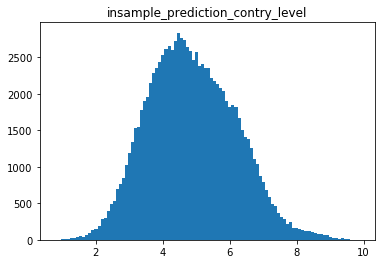

In [182]:
# final score
lgb_model.fit(X_train,np.log1p(y_train))
y_insample_pred=np.expm1(lgb_model.predict(X_train))
plt.hist(np.log1p(y_insample_pred),bins=100)
plt.title("insample_prediction_contry_level")
plt.show()

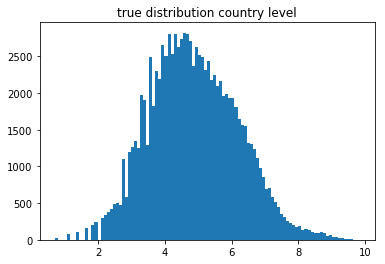

In [183]:
plt.hist(np.log1p(y_train),bins=100)
plt.title("true distribution country level")
plt.show()

In [184]:
train['pred_view']=y_insample_pred

In [ ]:
# train.head()

In [185]:
train_game_2000=train[['Game_ID','Rounded Viewers','pred_view']].groupby('Game_ID').sum()

In [186]:
mean_absolute_percentage_error(train_game_2000['Rounded Viewers'],train_game_2000['pred_view'])
# 0.03317801055900027

0.03317801055900027

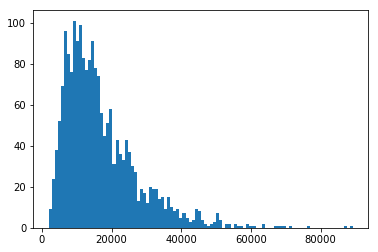

In [187]:
plt.hist(train_game_2000['Rounded Viewers'],bins=100)
plt.show()

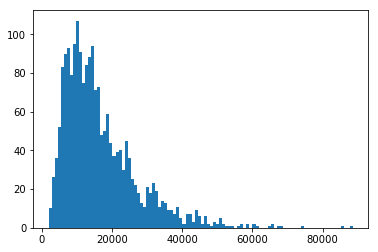

In [188]:
plt.hist(train_game_2000['pred_view'],bins=100)
plt.show()

# submission

In [189]:
y_pred=np.expm1(lgb_model.predict(X_test))

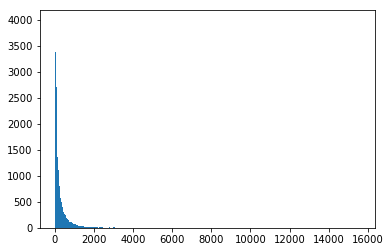

In [191]:
plt.hist(y_pred,bins=500)
plt.show()

In [ ]:
# plt.hist(y_train,bins=100)
# plt.show()

In [193]:
# y_pred.shape

In [210]:
test['Total_Viewers']=y_pred

In [211]:
test.head()

Season   Game_ID   Game_Date Away_Team Home_Team  Total_Viewers  Away_PR  \
0  2016-17  21600010  2016-10-26       DEN       NOP      86.103462     24.0   
1  2016-17  21600010  2016-10-26       DEN       NOP     112.340287     24.0   
2  2016-17  21600010  2016-10-26       DEN       NOP     127.481276     24.0   
3  2016-17  21600010  2016-10-26       DEN       NOP     146.171011     24.0   
4  2016-17  21600010  2016-10-26       DEN       NOP     292.189602     24.0   

   Home_PR  Avg_PR  Away_PR_2  Home_PR_2  Avg_PR_2  Away_Count_ASG  \
0     26.0    25.0      576.0      676.0     625.0               0   
1     26.0    25.0      576.0      676.0     625.0               0   
2     26.0    25.0      576.0      676.0     625.0               0   
3     26.0    25.0      576.0      676.0     625.0               0   
4     26.0    25.0      576.0      676.0     625.0               0   

   Home_Count_ASG day_of_week  month Country  
0               2   Wednesday     10    C208  
1               2   Wednesday     10     C33  
2               2   Wednesday     10    C191  
3               2   Wednesday     10    C150  
4               2   Wednesday     10    C154

In [ ]:
# aggregate over country

In [212]:
submission=test[['Season','Game_ID','Game_Date','Away_Team','Home_Team','Total_Viewers']]

In [ ]:
# submission=test.drop(columns=['month','Country','day_of_week','Away_Count_ASG','Home_Count_ASG'])

In [213]:
submission=submission.groupby(by=['Season','Game_Date','Game_ID','Away_Team','Home_Team']).sum()

In [214]:
submission.reset_index(inplace=True)

In [215]:
submission.head()

Season   Game_Date   Game_ID Away_Team Home_Team  Total_Viewers
0  2016-17  2016-10-26  21600010       DEN       NOP   10719.815192
1  2016-17  2016-10-28  21600023       HOU       DAL   19274.980246
2  2016-17  2016-10-29  21600026       ATL       PHI   25897.321933
3  2016-17  2016-10-29  21600027       BOS       CHA   31508.928850
4  2016-17  2016-11-01  21600048       LAL       IND   16629.867076

In [216]:
submission['Total_Viewers']=submission['Total_Viewers'].round(0)

In [217]:
submission.head()

Season   Game_Date   Game_ID Away_Team Home_Team  Total_Viewers
0  2016-17  2016-10-26  21600010       DEN       NOP        10720.0
1  2016-17  2016-10-28  21600023       HOU       DAL        19275.0
2  2016-17  2016-10-29  21600026       ATL       PHI        25897.0
3  2016-17  2016-10-29  21600027       BOS       CHA        31509.0
4  2016-17  2016-11-01  21600048       LAL       IND        16630.0

In [219]:
submission.to_csv("../output/submission_7_12.csv",index=False)